In [1]:
# 텐서플로우 디바이스 목록 출력
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11390963579801740324
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6284115968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17065794314568620608
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
# GPU 사용
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import numpy as np

actions = [
    'next',
    'back',
    'pgup',
    'pgdn'
]

data = np.concatenate([
    np.load('dataset/seq_next_1684645312.npy'),
    np.load('dataset/seq_back_1684645312.npy'),
    np.load('dataset/seq_pgup_1685615499.npy'),
    np.load('dataset/seq_pgdn_1685615499.npy')
], axis=0)

data.shape

(2990, 30, 100)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2990, 30, 99)
(2990,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2990, 4)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2093, 30, 99) (2093, 4)
(897, 30, 99) (897, 4)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/500
66/66 [==============================] - ETA: 0s - loss: 0.2887 - acc: 0.9403
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\model.h5
66/66 [==============================] - 7s 28ms/step - loss: 0.2887 - acc: 0.9403 - val_loss: 0.0120 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/500
66/66 [==============================] - ETA: 0s - loss: 0.0049 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
66/66 [==============================] - 1s 22ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/500
65/66 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
66/66 [==============================] - 2s 34ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/500
66/66 [==============================] - ETA: 0s - loss: 8.3530e-04 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
66/66 [============

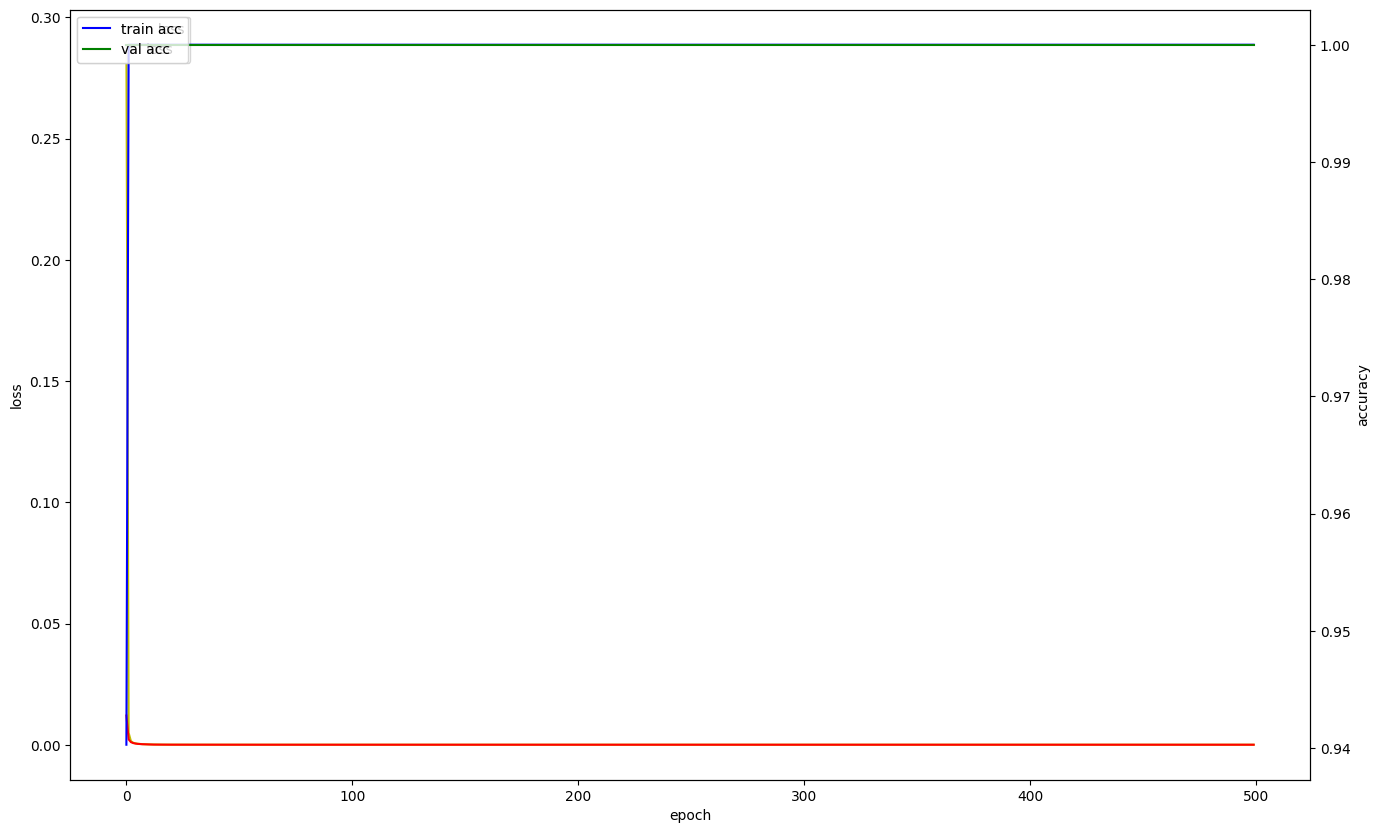

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

29/29 [==============================] - 1s 7ms/step


array([[[476,   0],
        [  0, 421]],

       [[421,   0],
        [  0, 476]]], dtype=int64)